In [19]:
import pandas as pd
import pandas_datareader.data as web
from utils import api_key, get_symbols
import matplotlib.pyplot as plt


In [10]:
prices = get_symbols(symbols=['AAPL', 'CSCO'], source='quandl', start='2015-01-01', end='2017-01-01')
prices

,,open,high,low,close,volume
date,symbol,,,,,
2016-12-30,AAPL,115.209202,115.752409,114.004271,114.389454,30586265.0
2016-12-29,AAPL,115.011672,115.663027,114.962290,115.288214,15039519.0
2016-12-28,AAPL,116.068456,116.558923,114.764760,115.317843,20905892.0
2016-12-27,AAPL,115.080808,116.344998,115.051178,115.811668,18296855.0
2016-12-23,AAPL,114.162295,115.080808,114.162295,115.080808,14249484.0
...,...,...,...,...,...,...
2015-01-08,CSCO,25.094076,25.595228,25.030293,25.066740,40906993.0
2015-01-07,CSCO,24.729601,24.966509,24.583811,24.875391,27570801.0
2015-01-06,CSCO,24.725045,25.221642,24.638482,24.647594,47297634.0


In [11]:
groupby_sym = prices.groupby('symbol')

In [12]:
price_shifted = groupby_sym.shift(1).volume
change_in_vol = groupby_sym.volume.diff(1)

features = pd.DataFrame(index = prices.index)

features['volume_change_ratio'] = change_in_vol / price_shifted

features['itd_chg'] = groupby_sym.close.shift(0) - groupby_sym.open.shift(0) / groupby_sym.open.shift(0)

features['day_of_week'] = features.index.get_level_values('date').weekday

features['day_of_month'] = features.index.get_level_values('date').day

features.dropna(inplace=True)

features

,,volume_change_ratio,itd_chg,day_of_week,day_of_month
date,symbol,,,,
2016-12-29,AAPL,-0.508292,114.288214,3,29
2016-12-28,AAPL,0.390064,114.317843,2,28
2016-12-27,AAPL,-0.124799,114.811668,1,27
2016-12-23,AAPL,-0.221206,114.080808,4,23
2016-12-22,AAPL,0.830653,113.853649,3,22
...,...,...,...,...,...
2015-01-08,CSCO,0.229229,24.066740,3,8
2015-01-07,CSCO,-0.326013,23.875391,2,7
2015-01-06,CSCO,0.715497,23.647594,1,6


In [13]:
### Creating the outcomes table
outcomes = pd.DataFrame(index = prices.index)

outcomes['open_chg'] = groupby_sym.open.shift(-1)/groupby_sym.close.shift(0) - 1

outcomes['close_chg'] = groupby_sym.close.shift(-1) / groupby_sym.close.shift(0) - 1

outcomes['close_5'] = groupby_sym.close.shift(-5) / groupby_sym.close.shift(0) - 1

outcomes

,,open_chg,close_chg,close_5
date,symbol,,,
2016-12-30,AAPL,0.005439,0.007857,0.004058
2016-12-29,AAPL,0.006768,0.000257,0.002827
2016-12-28,AAPL,-0.002055,0.004282,0.001627
2016-12-27,AAPL,-0.014242,-0.006311,-0.005287
2016-12-23,AAPL,-0.001459,-0.001974,-0.004720
...,...,...,...,...
2015-01-08,CSCO,-0.013450,-0.007634,NaN
2015-01-07,CSCO,-0.006044,-0.009158,NaN
2015-01-06,CSCO,0.009982,0.000370,NaN


In [14]:
y = outcomes.close_5
x = features

xy = x.join(y).dropna()

y = xy[y.name]
x = xy[x.columns]

In [15]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x, y)
print('RSQ: ', str(model.score(x,y)))
print('Coefficients:', pd.Series(model.coef_, index=x.columns).sort_index())

RSQ:  0.001259468679053466
Coefficients: day_of_month          -0.000051
day_of_week           -0.000213
itd_chg               -0.000014
volume_change_ratio    0.002531
dtype: float64


In [16]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_features=3)
model.fit(x,y)

print('RSQ: ', str(model.score(x,y)))
print('Coefficients:') 
print(pd.Series(model.feature_importances_, index=x.columns).sort_values(ascending=False))

RSQ:  0.8608229076726049
Coefficients:
itd_chg                0.420618
volume_change_ratio    0.295289
day_of_month           0.202081
day_of_week            0.082011
dtype: float64


In [17]:
y_pred = model.predict(x)
print(pd.Series(model.predict(x.tail(2)), index = x.index[-2]))

2015-01-12 00:00:00   -0.027812
CSCO                  -0.003387
dtype: float64


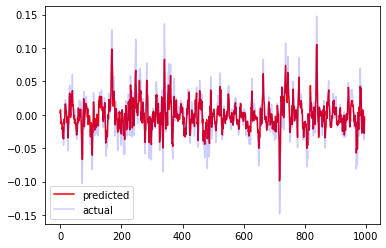

In [21]:
plt.plot(y_pred, label='predicted', color='red')
plt.plot(y.to_numpy(), label='actual', alpha=0.2, color='blue')
plt.legend()
plt.show()